# **Analisis Sentimen Ulasan Aplikasi Canva di Google Play Store**

## **Import Library**

In [ ]:
!pip install sastrawi

In [ ]:
!pip install wordcloud

In [ ]:
!pip install tensorflow

In [ ]:
!pip install catboost

In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt  
import seaborn as sns  

import datetime as dt 
import re  
import string 
import nltk
from nltk.tokenize import word_tokenize 
from nltk.corpus import stopwords 

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory  
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory  

from wordcloud import WordCloud  

import csv
import requests
from io import StringIO

from sklearn.utils import resample
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, Dense, Dropout, SpatialDropout1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [4]:
pd.options.mode.chained_assignment = None 
seed = 0
np.random.seed(seed) 

nltk.download('punkt') 
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\asus\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\asus\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## **Load Data**

In [ ]:
data = pd.read_csv("review_canva.csv")

In [6]:
data.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,a27bf303-a8cc-4763-a829-839501445457,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,kadang kalo udah kebanyakan slide suka rada er...,3,7,2.306.0,2025-04-08 15:57:21,"Hai Jelova, terima kasih telah menghubungi Can...",2025-04-09 09:46:11,2.306.0
1,02449ddf-1610-4b9b-95da-1f8169813e5d,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"aplikasinya sangat bagus,berguna bet untuk per...",5,57,2.306.0,2025-04-09 13:21:06,NaN,NaN,2.306.0
2,976e8f99-a7bc-419c-9958-d260fe33b903,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Setelah update, Canva ada bug. Biasanya saat m...",3,18,2.306.0,2025-04-04 12:28:47,"Hai Natalia, terima kasih telah menghubungi Ca...",2025-04-06 09:32:24,2.306.0
3,e35b71af-1bc3-44ea-8f80-ef6bcba69e19,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Saya ingin menyampaikan kekecewaan terhadap ap...,1,16,2.306.0,2025-04-07 15:56:46,"Hai Abdah, terima kasih telah menghubungi Canv...",2025-04-08 10:11:37,2.306.0
4,5274cee6-bcf0-4a64-832f-2453a91da93d,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Menggunakan Canva pro memang banyak pilihannya...,4,40,2.305.0,2025-03-23 21:51:48,"Hai Sahroni, terima kasih telah menghubungi Ca...",2025-03-25 09:10:43,2.305.0


In [7]:
data.shape

(85500, 11)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85500 entries, 0 to 85499
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              85500 non-null  object
 1   userName              85500 non-null  object
 2   userImage             85500 non-null  object
 3   content               85500 non-null  object
 4   score                 85500 non-null  int64 
 5   thumbsUpCount         85500 non-null  int64 
 6   reviewCreatedVersion  73742 non-null  object
 7   at                    85500 non-null  object
 8   replyContent          28884 non-null  object
 9   repliedAt             28884 non-null  object
 10  appVersion            73742 non-null  object
dtypes: int64(2), object(9)
memory usage: 7.2+ MB


## **Text Preprocessing**

### **Cleaning**

In [9]:
data.duplicated().sum()

0

In [10]:
data.isna().sum()

reviewId                    0
userName                    0
userImage                   0
content                     0
score                       0
thumbsUpCount               0
reviewCreatedVersion    11758
at                          0
replyContent            56616
repliedAt               56616
appVersion              11758
dtype: int64

Akan digunakan kolom `content` dan `score` saja.

In [11]:
df = data[['content', 'score']]
df.head()

,content,score
0,kadang kalo udah kebanyakan slide suka rada er...,3
1,"aplikasinya sangat bagus,berguna bet untuk per...",5
2,"Setelah update, Canva ada bug. Biasanya saat m...",3
3,Saya ingin menyampaikan kekecewaan terhadap ap...,1
4,Menggunakan Canva pro memang banyak pilihannya...,4


In [12]:
def cleaning(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text) # Menghapus mentions/username
    text = re.sub(r'#[A-Za-z0-9]+', '', text) # Menghapus hashtag
    text = re.sub(r'RT[\s]', '', text) # Menghapus RT
    text = re.sub(r"http\S+", '', text) # Menghapus tautan
    text = re.sub(r'[0-9]+', '', text) # Menghapus angka
    text = re.sub(r'[^\w\s]', '', text) # Menghapus karakter non-alfanumerik


    text = text.replace('\n', ' ') # Mengubah baris baru menjadi spasi
    text = text.translate(str.maketrans('', '', string.punctuation)) # Menghapus tanda baca
    text = text.strip(' ') # Menghapus spasi di awal dan akhir teks
    return text

In [13]:
df_clean = df.copy()
df_clean['clean_text'] = df_clean['content'].apply(cleaning)

In [14]:
df_clean.head()

,content,score,clean_text
0,kadang kalo udah kebanyakan slide suka rada er...,3,kadang kalo udah kebanyakan slide suka rada er...
1,"aplikasinya sangat bagus,berguna bet untuk per...",5,aplikasinya sangat bagusberguna bet untuk perc...
2,"Setelah update, Canva ada bug. Biasanya saat m...",3,Setelah update Canva ada bug Biasanya saat mau...
3,Saya ingin menyampaikan kekecewaan terhadap ap...,1,Saya ingin menyampaikan kekecewaan terhadap ap...
4,Menggunakan Canva pro memang banyak pilihannya...,4,Menggunakan Canva pro memang banyak pilihannya...


### **Case Folding**

In [15]:
def casefolding(text): 
    text = text.lower()
    return text

In [16]:
df_clean['clean_text'] = df_clean['clean_text'].apply(casefolding)

In [17]:
df_clean.head()

,content,score,clean_text
0,kadang kalo udah kebanyakan slide suka rada er...,3,kadang kalo udah kebanyakan slide suka rada er...
1,"aplikasinya sangat bagus,berguna bet untuk per...",5,aplikasinya sangat bagusberguna bet untuk perc...
2,"Setelah update, Canva ada bug. Biasanya saat m...",3,setelah update canva ada bug biasanya saat mau...
3,Saya ingin menyampaikan kekecewaan terhadap ap...,1,saya ingin menyampaikan kekecewaan terhadap ap...
4,Menggunakan Canva pro memang banyak pilihannya...,4,menggunakan canva pro memang banyak pilihannya...


### **Slangwords Handling**

In [18]:
slangwords = {"@": "di", "abis": "habis", "wtb": "beli", "masi": "masih", "wts": "jual", "wtt": "tukar", "bgt": "banget", "maks": "maksimal", "plisss": "tolong", "bgttt": "banget", "indo": "indonesia", "bgtt": "banget", "ad": "ada", "rv": "redvelvet", "plis": "tolong", "pls": "tolong", "cr": "sumber", "cod": "bayar ditempat", "adlh": "adalah", "afaik": "as far as i know", "ahaha": "haha", "aj": "saja", "ajep-ajep": "dunia gemerlap", "ak": "saya", "akika": "aku", "akkoh": "aku", "akuwh": "aku", "alay": "norak", "alow": "halo", "ambilin": "ambilkan", "ancur": "hancur", "anjrit": "anjing", "anter": "antar", "ap2": "apa-apa", "apasih": "apa sih", "apes": "sial", "aps": "apa", "aq": "saya", "aquwh": "aku", "asbun": "asal bunyi", "aseekk": "asyik", "asekk": "asyik", "asem": "asam", "aspal": "asli tetapi palsu", "astul": "asal tulis", "ato": "atau", "au ah": "tidak mau tahu", "awak": "saya", "ay": "sayang", "ayank": "sayang", "b4": "sebelum", "bakalan": "akan", "bandes": "bantuan desa", "bangedh": "banget", "banpol": "bantuan polisi", "banpur": "bantuan tempur", "basbang": "basi", "bcanda": "bercanda", "bdg": "bandung", "begajulan": "nakal", "beliin": "belikan", "bencong": "banci", "bentar": "sebentar", "ber3": "bertiga", "beresin": "membereskan", "bete": "bosan", "beud": "banget", "bg": "abang", "bgmn": "bagaimana", "bgt": "banget", "bijimane": "bagaimana", "bintal": "bimbingan mental", "bkl": "akan", "bknnya": "bukannya", "blegug": "bodoh", "blh": "boleh", "bln": "bulan", "blum": "belum", "bnci": "benci", "bnran": "yang benar", "bodor": "lucu", "bokap": "ayah", "boker": "buang air besar", "bokis": "bohong", "boljug": "boleh juga", "bonek": "bocah nekat", "boyeh": "boleh", "br": "baru", "brg": "bareng", "bro": "saudara laki-laki", "bru": "baru", "bs": "bisa", "bsen": "bosan", "bt": "buat", "btw": "ngomong-ngomong", "buaya": "tidak setia", "bubbu": "tidur", "bubu": "tidur", "bumil": "ibu hamil", "bw": "bawa", "bwt": "buat", "byk": "banyak", "byrin": "bayarkan", "cabal": "sabar", "cadas": "keren", "calo": "makelar", "can": "belum", "capcus": "pergi", "caper": "cari perhatian", "ce": "cewek", "cekal": "cegah tangkal", "cemen": "penakut", "cengengesan": "tertawa", "cepet": "cepat", "cew": "cewek", "chuyunk": "sayang", "cimeng": "ganja", "cipika cipiki": "cium pipi kanan cium pipi kiri", "ciyh": "sih", "ckepp": "cakep", "ckp": "cakep", "cmiiw": "correct me if i'm wrong", "cmpur": "campur", "cong": "banci", "conlok": "cinta lokasi", "cowwyy": "maaf", "cp": "siapa", "cpe": "capek", "cppe": "capek", "cucok": "cocok", "cuex": "cuek", "cumi": "Cuma miscall", "cups": "culun", "curanmor": "pencurian kendaraan bermotor", "curcol": "curahan hati colongan", "cwek": "cewek", "cyin": "cinta", "d": "di", "dah": "deh", "dapet": "dapat", "de": "adik", "dek": "adik", "demen": "suka", "deyh": "deh", "dgn": "dengan", "diancurin": "dihancurkan", "dimaafin": "dimaafkan", "dimintak": "diminta", "disono": "di sana", "dket": "dekat", "dkk": "dan kawan-kawan", "dll": "dan lain-lain", "dlu": "dulu", "dngn": "dengan", "dodol": "bodoh", "doku": "uang", "dongs": "dong", "dpt": "dapat", "dri": "dari", "drmn": "darimana", "drtd": "dari tadi", "dst": "dan seterusnya", "dtg": "datang", "duh": "aduh", "duren": "durian", "ed": "edisi", "egp": "emang gue pikirin", "eke": "aku", "elu": "kamu", "emangnya": "memangnya", "emng": "memang", "endak": "tidak", "enggak": "tidak", "envy": "iri", "ex": "mantan", "fax": "facsimile", "fifo": "first in first out", "folbek": "follow back", "fyi": "sebagai informasi", "gaada": "tidak ada uang", "gag": "tidak", "gaje": "tidak jelas", "gak papa": "tidak apa-apa", "gan": "juragan", "gaptek": "gagap teknologi", "gatek": "gagap teknologi", "gawe": "kerja", "gbs": "tidak bisa", "gebetan": "orang yang disuka", "geje": "tidak jelas", "gepeng": "gelandangan dan pengemis", "ghiy": "lagi", "gile": "gila", "gimana": "bagaimana", "gino": "gigi nongol", "githu": "gitu", "gj": "tidak jelas", "gmana": "bagaimana", "gn": "begini", "goblok": "bodoh", "golput": "golongan putih", "gowes": "mengayuh sepeda", "gpny": "tidak punya", "gr": "gede rasa", "gretongan": "gratisan", "gtau": "tidak tahu", "gua": "saya", "guoblok": "goblok", "gw": "saya", "ha": "tertawa", "haha": "tertawa", "hallow": "halo", "hankam": "pertahanan dan keamanan", "hehe": "he", "helo": "halo", "hey": "hai", "hlm": "halaman", "hny": "hanya", "hoax": "isu bohong", "hr": "hari", "hrus": "harus", "hubdar": "perhubungan darat", "huff": "mengeluh", "hum": "rumah", "humz": "rumah", "ilang": "hilang", "ilfil": "tidak suka", "imho": "in my humble opinion", "imoetz": "imut", "item": "hitam", "itungan": "hitungan", "iye": "iya", "ja": "saja", "jadiin": "jadi", "jaim": "jaga image", "jayus": "tidak lucu", "jdi": "jadi", "jem": "jam", "jga": "juga", "jgnkan": "jangankan", "jir": "anjing", "jln": "jalan", "jomblo": "tidak punya pacar", "jubir": "juru bicara", "jutek": "galak", "k": "ke", "kab": "kabupaten", "kabor": "kabur", "kacrut": "kacau", "kadiv": "kepala divisi", "kagak": "tidak", "kalo": "kalau", "kampret": "sialan", "kamtibmas": "keamanan dan ketertiban masyarakat", "kamuwh": "kamu", "kanwil": "kantor wilayah", "karna": "karena", "kasubbag": "kepala subbagian", "katrok": "kampungan", "kayanya": "kayaknya", "kbr": "kabar", "kdu": "harus", "kec": "kecamatan", "kejurnas": "kejuaraan nasional", "kekeuh": "keras kepala", "kel": "kelurahan", "kemaren": "kemarin", "kepengen": "mau", "kepingin": "mau", "kepsek": "kepala sekolah", "kesbang": "kesatuan bangsa", "kesra": "kesejahteraan rakyat", "ketrima": "diterima", "kgiatan": "kegiatan", "kibul": "bohong", "kimpoi": "kawin", "kl": "kalau", "klianz": "kalian", "kloter": "kelompok terbang", "klw": "kalau", "km": "kamu", "kmps": "kampus", "kmrn": "kemarin", "knal": "kenal", "knp": "kenapa", "kodya": "kota madya", "komdis": "komisi disiplin", "komsov": "komunis sovyet", "kongkow": "kumpul bareng teman-teman", "kopdar": "kopi darat", "korup": "korupsi", "kpn": "kapan", "krenz": "keren", "krm": "kirim", "kt": "kita", "ktmu": "ketemu", "ktr": "kantor", "kuper": "kurang pergaulan", "kw": "imitasi", "kyk": "seperti", "la": "lah", "lam": "salam", "lamp": "lampiran", "lanud": "landasan udara", "latgab": "latihan gabungan", "lebay": "berlebihan", "leh": "boleh", "lelet": "lambat", "lemot": "lambat", "lgi": "lagi", "lgsg": "langsung", "liat": "lihat", "litbang": "penelitian dan pengembangan", "lmyn": "lumayan", "lo": "kamu", "loe": "kamu", "lola": "lambat berfikir", "louph": "cinta", "low": "kalau", "lp": "lupa", "luber": "langsung, umum, bebas, dan rahasia", "luchuw": "lucu", "lum": "belum", "luthu": "lucu", "lwn": "lawan", "maacih": "terima kasih", "mabal": "bolos", "macem": "macam", "macih": "masih", "maem": "makan", "magabut": "makan gaji buta", "maho": "homo", "mak jang": "kaget", "maksain": "memaksa", "malem": "malam", "mam": "makan", "maneh": "kamu", "maniez": "manis", "mao": "mau", "masukin": "masukkan", "melu": "ikut", "mepet": "dekat sekali", "mgu": "minggu", "migas": "minyak dan gas bumi", "mikol": "minuman beralkohol", "miras": "minuman keras", "mlah": "malah", "mngkn": "mungkin", "mo": "mau", "mokad": "mati", "moso": "masa", "mpe": "sampai", "msk": "masuk", "mslh": "masalah", "mt": "makan teman", "mubes": "musyawarah besar", "mulu": "melulu", "mumpung": "selagi", "munas": "musyawarah nasional", "muntaber": "muntah dan berak", "musti": "mesti", "muupz": "maaf", "mw": "now watching", "n": "dan", "nanam": "menanam", "nanya": "bertanya", "napa": "kenapa", "napi": "narapidana", "napza": "narkotika, alkohol, psikotropika, dan zat adiktif ", "narkoba": "narkotika, psikotropika, dan obat terlarang", "nasgor": "nasi goreng", "nda": "tidak", "ndiri": "sendiri", "ne": "ini", "nekolin": "neokolonialisme", "nembak": "menyatakan cinta", "ngabuburit": "menunggu berbuka puasa", "ngaku": "mengaku", "ngambil": "mengambil", "nganggur": "tidak punya pekerjaan", "ngapah": "kenapa", "ngaret": "terlambat", "ngasih": "memberikan", "ngebandel": "berbuat bandel", "ngegosip": "bergosip", "ngeklaim": "mengklaim", "ngeksis": "menjadi eksis", "ngeles": "berkilah", "ngelidur": "menggigau", "ngerampok": "merampok", "ngga": "tidak", "ngibul": "berbohong", "ngiler": "mau", "ngiri": "iri", "ngisiin": "mengisikan", "ngmng": "bicara", "ngomong": "bicara", "ngubek2": "mencari-cari", "ngurus": "mengurus", "nie": "ini", "nih": "ini", "niyh": "nih", "nmr": "nomor", "nntn": "nonton", "nobar": "nonton bareng", "np": "now playing", "ntar": "nanti", "ntn": "nonton", "numpuk": "bertumpuk", "nutupin": "menutupi", "nyari": "mencari", "nyekar": "menyekar", "nyicil": "mencicil", "nyoblos": "mencoblos", "nyokap": "ibu", "ogah": "tidak mau", "ol": "online", "ongkir": "ongkos kirim", "oot": "out of topic", "org2": "orang-orang", "ortu": "orang tua", "otda": "otonomi daerah", "otw": "on the way, sedang di jalan", "pacal": "pacar", "pake": "pakai", "pala": "kepala", "pansus": "panitia khusus", "parpol": "partai politik", "pasutri": "pasangan suami istri", "pd": "pada", "pede": "percaya diri", "pelatnas": "pemusatan latihan nasional", "pemda": "pemerintah daerah", "pemkot": "pemerintah kota", "pemred": "pemimpin redaksi", "penjas": "pendidikan jasmani", "perda": "peraturan daerah", "perhatiin": "perhatikan", "pesenan": "pesanan", "pgang": "pegang", "pi": "tapi", "pilkada": "pemilihan kepala daerah", "pisan": "sangat", "pk": "penjahat kelamin", "plg": "paling", "pmrnth": "pemerintah", "polantas": "polisi lalu lintas", "ponpes": "pondok pesantren", "pp": "pulang pergi", "prg": "pergi", "prnh": "pernah", "psen": "pesan", "pst": "pasti", "pswt": "pesawat", "pw": "posisi nyaman", "qmu": "kamu", "rakor": "rapat koordinasi", "ranmor": "kendaraan bermotor", "re": "reply", "ref": "referensi", "rehab": "rehabilitasi", "rempong": "sulit", "repp": "balas", "restik": "reserse narkotika", "rhs": "rahasia", "rmh": "rumah", "ru": "baru", "ruko": "rumah toko", "rusunawa": "rumah susun sewa", "ruz": "terus", "saia": "saya", "salting": "salah tingkah", "sampe": "sampai", "samsek": "sama sekali", "sapose": "siapa", "satpam": "satuan pengamanan", "sbb": "sebagai berikut", "sbh": "sebuah", "sbnrny": "sebenarnya", "scr": "secara", "sdgkn": "sedangkan", "sdkt": "sedikit", "se7": "setuju", "sebelas dua belas": "mirip", "sembako": "sembilan bahan pokok", "sempet": "sempat", "sendratari": "seni drama tari", "sgt": "sangat", "shg": "sehingga", "siech": "sih", "sikon": "situasi dan kondisi", "sinetron": "sinema elektronik", "siramin": "siramkan", "sj": "saja", "skalian": "sekalian", "sklh": "sekolah", "skt": "sakit", "slesai": "selesai", "sll": "selalu", "slma": "selama", "slsai": "selesai", "smpt": "sempat", "smw": "semua", "sndiri": "sendiri", "soljum": "sholat jumat", "songong": "sombong", "sory": "maaf", "sosek": "sosial-ekonomi", "sotoy": "sok tahu", "spa": "siapa", "sppa": "siapa", "spt": "seperti", "srtfkt": "sertifikat", "stiap": "setiap", "stlh": "setelah", "suk": "masuk", "sumpek": "sempit", "syg": "sayang", "t4": "tempat", "tajir": "kaya", "tau": "tahu", "taw": "tahu", "td": "tadi", "tdk": "tidak", "teh": "kakak perempuan", "telat": "terlambat", "telmi": "telat berpikir", "temen": "teman", "tengil": "menyebalkan", "tepar": "terkapar", "tggu": "tunggu", "tgu": "tunggu", "thankz": "terima kasih", "thn": "tahun", "tilang": "bukti pelanggaran", "tipiwan": "TvOne", "tks": "terima kasih", "tlp": "telepon", "tls": "tulis", "tmbah": "tambah", "tmen2": "teman-teman", "tmpah": "tumpah", "tmpt": "tempat", "tngu": "tunggu", "tnyta": "ternyata", "tokai": "tai", "toserba": "toko serba ada", "tpi": "tapi", "trdhulu": "terdahulu", "trima": "terima kasih", "trm": "terima", "trs": "terus", "trutama": "terutama", "ts": "penulis", "tst": "tahu sama tahu", "ttg": "tentang", "tuch": "tuh", "tuir": "tua", "tw": "tahu", "u": "kamu", "ud": "sudah", "udah": "sudah", "ujg": "ujung", "ul": "ulangan", "unyu": "lucu", "uplot": "unggah", "urang": "saya", "usah": "perlu", "utk": "untuk", "valas": "valuta asing", "w/": "dengan", "wadir": "wakil direktur", "wamil": "wajib militer", "warkop": "warung kopi", "warteg": "warung tegal", "wat": "buat", "wkt": "waktu", "wtf": "what the fuck", "xixixi": "tertawa", "ya": "iya", "yap": "iya", "yaudah": "ya sudah", "yawdah": "ya sudah", "yg": "yang", "yl": "yang lain", "yo": "iya", "yowes": "ya sudah", "yup": "iya", "7an": "tujuan", "ababil": "abg labil", "acc": "accord", "adlah": "adalah", "adoh": "aduh", "aha": "tertawa", "aing": "saya", "aja": "saja", "ajj": "saja", "aka": "dikenal juga sebagai", "akko": "aku", "akku": "aku", "akyu": "aku", "aljasa": "asal jadi saja", "ama": "sama", "ambl": "ambil", "anjir": "anjing", "ank": "anak", "ap": "apa", "apaan": "apa", "ape": "apa", "aplot": "unggah", "apva": "apa", "aqu": "aku", "asap": "sesegera mungkin", "aseek": "asyik", "asek": "asyik", "aseknya": "asyiknya", "asoy": "asyik", "astrojim": "astagfirullahaladzim", "ath": "kalau begitu", "atuh": "kalau begitu", "ava": "avatar", "aws": "awas", "ayang": "sayang", "ayok": "ayo", "bacot": "banyak bicara", "bales": "balas", "bangdes": "pembangunan desa", "bangkotan": "tua", "banpres": "bantuan presiden", "bansarkas": "bantuan sarana kesehatan", "bazis": "badan amal, zakat, infak, dan sedekah", "bcoz": "karena", "beb": "sayang", "bejibun": "banyak", "belom": "belum", "bener": "benar", "ber2": "berdua", "berdikari": "berdiri di atas kaki sendiri", "bet": "banget", "beti": "beda tipis", "beut": "banget", "bgd": "banget", "bgs": "bagus", "bhubu": "tidur", "bimbuluh": "bimbingan dan penyuluhan", "bisi": "kalau-kalau", "bkn": "bukan", "bl": "beli", "blg": "bilang", "blm": "belum", "bls": "balas", "bnchi": "benci", "bngung": "bingung", "bnyk": "banyak", "bohay": "badan aduhai", "bokep": "porno", "bokin": "pacar", "bole": "boleh", "bolot": "bodoh", "bonyok": "ayah ibu", "bpk": "bapak", "brb": "segera kembali", "brngkt": "berangkat", "brp": "berapa", "brur": "saudara laki-laki", "bsa": "bisa", "bsk": "besok", "bu_bu": "tidur", "bubarin": "bubarkan", "buber": "buka bersama", "bujubune": "luar biasa", "buser": "buru sergap", "bwhn": "bawahan", "byar": "bayar", "byr": "bayar", "c8": "chat", "cabut": "pergi", "caem": "cakep", "cama-cama": "sama-sama", "cangcut": "celana dalam", "cape": "capek", "caur": "jelek", "cekak": "tidak ada uang", "cekidot": "coba lihat", "cemplungin": "cemplungkan", "ceper": "pendek", "ceu": "kakak perempuan", "cewe": "cewek", "cibuk": "sibuk", "cin": "cinta", "ciye": "cie", "ckck": "ck", "clbk": "cinta lama bersemi kembali", "cmpr": "campur", "cnenk": "senang", "congor": "mulut", "cow": "cowok", "coz": "karena", "cpa": "siapa", "gokil": "gila", "gombal": "suka merayu", "gpl": "tidak pakai lama", "gpp": "tidak apa-apa", "gretong": "gratis", "gt": "begitu", "gtw": "tidak tahu", "gue": "saya", "guys": "teman-teman", "gws": "cepat sembuh", "haghaghag": "tertawa", "hakhak": "tertawa", "handak": "bahan peledak", "hansip": "pertahanan sipil", "hellow": "halo", "helow": "halo", "hi": "hai", "hlng": "hilang", "hnya": "hanya", "houm": "rumah", "hrs": "harus", "hubad": "hubungan angkatan darat", "hubla": "perhubungan laut", "huft": "mengeluh", "humas": "hubungan masyarakat", "idk": "saya tidak tahu", "ilfeel": "tidak suka", "imba": "jago sekali", "imoet": "imut", "info": "informasi", "itung": "hitung", "isengin": "bercanda", "iyala": "iya lah", "iyo": "iya", "jablay": "jarang dibelai", "jadul": "jaman dulu", "jancuk": "anjing", "jd": "jadi", "jdikan": "jadikan", "jg": "juga", "jgn": "jangan", "jijay": "jijik", "jkt": "jakarta", "jnj": "janji", "jth": "jatuh", "jurdil": "jujur adil", "jwb": "jawab", "ka": "kakak", "kabag": "kepala bagian", "kacian": "kasihan", "kadit": "kepala direktorat", "kaga": "tidak", "kaka": "kakak", "kamtib": "keamanan dan ketertiban", "kamuh": "kamu", "kamyu": "kamu", "kapt": "kapten", "kasat": "kepala satuan", "kasubbid": "kepala subbidang", "kau": "kamu", "kbar": "kabar", "kcian": "kasihan", "keburu": "terlanjur", "kedubes": "kedutaan besar", "kek": "seperti", "keknya": "kayaknya", "keliatan": "kelihatan", "keneh": "masih", "kepikiran": "terpikirkan", "kepo": "mau tahu urusan orang", "kere": "tidak punya uang", "kesian": "kasihan", "ketauan": "ketahuan", "keukeuh": "keras kepala", "khan": "kan", "kibus": "kaki busuk", "kk": "kakak", "klian": "kalian", "klo": "kalau", "kluarga": "keluarga", "klwrga": "keluarga", "kmari": "kemari", "kmpus": "kampus", "kn": "kan", "knl": "kenal", "knpa": "kenapa", "kog": "kok", "kompi": "komputer", "komtiong": "komunis Tiongkok", "konjen": "konsulat jenderal", "koq": "kok", "kpd": "kepada", "kptsan": "keputusan", "krik": "garing", "krn": "karena", "ktauan": "ketahuan", "ktny": "katanya", "kudu": "harus", "kuq": "kok", "ky": "seperti", "kykny": "kayanya", "laka": "kecelakaan", "lambreta": "lambat", "lansia": "lanjut usia", "lapas": "lembaga pemasyarakatan", "lbur": "libur", "lekong": "laki-laki", "lg": "lagi", "lgkp": "lengkap", "lht": "lihat", "linmas": "perlindungan masyarakat", "lmyan": "lumayan", "lngkp": "lengkap", "loch": "loh", "lol": "tertawa", "lom": "belum", "loupz": "cinta", "lowh": "kamu", "lu": "kamu", "luchu": "lucu", "luff": "cinta", "luph": "cinta", "lw": "kamu", "lwt": "lewat", "maaciw": "terima kasih", "mabes": "markas besar", "macem-macem": "macam-macam", "madesu": "masa depan suram", "maen": "main", "mahatma": "maju sehat bersama", "mak": "ibu", "makasih": "terima kasih", "malah": "bahkan", "malu2in": "memalukan", "mamz": "makan", "manies": "manis", "mantep": "mantap", "markus": "makelar kasus", "mba": "mbak", "mending": "lebih baik", "mgkn": "mungkin", "mhn": "mohon", "miker": "minuman keras", "milis": "mailing list", "mksd": "maksud", "mls": "malas", "mnt": "minta", "moge": "motor gede", "mokat": "mati", "mosok": "masa", "msh": "masih", "mskpn": "meskipun", "msng2": "masing-masing", "muahal": "mahal", "muker": "musyawarah kerja", "mumet": "pusing", "muna": "munafik", "munaslub": "musyawarah nasional luar biasa", "musda": "musyawarah daerah", "muup": "maaf", "muuv": "maaf", "nal": "kenal", "nangis": "menangis", "naon": "apa", "napol": "narapidana politik", "naq": "anak", "narsis": "bangga pada diri sendiri", "nax": "anak", "ndak": "tidak", "ndut": "gendut", "nekolim": "neokolonialisme", "nelfon": "menelepon", "ngabis2in": "menghabiskan", "ngakak": "tertawa", "ngambek": "marah", "ngampus": "pergi ke kampus", "ngantri": "mengantri", "ngapain": "sedang apa", "ngaruh": "berpengaruh", "ngawur": "berbicara sembarangan", "ngeceng": "kumpul bareng-bareng", "ngeh": "sadar", "ngekos": "tinggal di kos", "ngelamar": "melamar", "ngeliat": "melihat", "ngemeng": "bicara terus-terusan", "ngerti": "mengerti", "nggak": "tidak", "ngikut": "ikut", "nginep": "menginap", "ngisi": "mengisi", "ngmg": "bicara", "ngocol": "lucu", "ngomongin": "membicarakan", "ngumpul": "berkumpul", "ni": "ini", "nyasar": "tersesat", "nyariin": "mencari", "nyiapin": "mempersiapkan", "nyiram": "menyiram", "nyok": "ayo", "o/": "oleh", "ok": "ok", "priksa": "periksa", "pro": "profesional", "psn": "pesan", "psti": "pasti", "puanas": "panas", "qmo": "kamu", "qt": "kita", "rame": "ramai", "raskin": "rakyat miskin", "red": "redaksi", "reg": "register", "rejeki": "rezeki", "renstra": "rencana strategis", "reskrim": "reserse kriminal", "sni": "sini", "somse": "sombong sekali", "sorry": "maaf", "sosbud": "sosial-budaya", "sospol": "sosial-politik", "sowry": "maaf", "spd": "sepeda", "sprti": "seperti", "spy": "supaya", "stelah": "setelah", "subbag": "subbagian", "sumbangin": "sumbangkan", "sy": "saya", "syp": "siapa", "tabanas": "tabungan pembangunan nasional", "tar": "nanti", "taun": "tahun", "tawh": "tahu", "tdi": "tadi", "te2p": "tetap", "tekor": "rugi", "telkom": "telekomunikasi", "telp": "telepon", "temen2": "teman-teman", "tengok": "menjenguk", "terbitin": "terbitkan", "tgl": "tanggal", "thanks": "terima kasih", "thd": "terhadap", "thx": "terima kasih", "tipi": "TV", "tkg": "tukang", "tll": "terlalu", "tlpn": "telepon", "tman": "teman", "tmbh": "tambah", "tmn2": "teman-teman", "tmph": "tumpah", "tnda": "tanda", "tnh": "tanah", "togel": "toto gelap", "tp": "tapi", "tq": "terima kasih", "trgntg": "tergantung", "trims": "terima kasih", "cb": "coba", "y": "ya", "munfik": "munafik", "reklamuk": "reklamasi", "sma": "sama", "tren": "trend", "ngehe": "kesal", "mz": "mas", "analisise": "analisis", "sadaar": "sadar", "sept": "september", "nmenarik": "menarik", "zonk": "bodoh", "rights": "benar", "simiskin": "miskin", "ngumpet": "sembunyi", "hardcore": "keras", "akhirx": "akhirnya", "solve": "solusi", "watuk": "batuk", "ngebully": "intimidasi", "masy": "masyarakat", "still": "masih", "tauk": "tahu", "mbual": "bual", "tioghoa": "tionghoa", "ngentotin": "senggama", "kentot": "senggama", "faktakta": "fakta", "sohib": "teman", "rubahnn": "rubah", "trlalu": "terlalu", "nyela": "cela", "heters": "pembenci", "nyembah": "sembah", "most": "paling", "ikon": "lambang", "light": "terang", "pndukung": "pendukung", "setting": "atur", "seting": "akting", "next": "lanjut", "waspadalah": "waspada", "gantengsaya": "ganteng", "parte": "partai", "nyerang": "serang", "nipu": "tipu", "ktipu": "tipu", "jentelmen": "berani", "buangbuang": "buang", "tsangka": "tersangka", "kurng": "kurang", "ista": "nista", "less": "kurang", "koar": "teriak", "paranoid": "takut", "problem": "masalah", "tahi": "kotoran", "tirani": "tiran", "tilep": "tilap", "happy": "bahagia", "tak": "tidak", "penertiban": "tertib", "uasai": "kuasa", "mnolak": "tolak", "trending": "trend", "taik": "tahi", "wkwkkw": "tertawa", "ahokncc": "ahok", "istaa": "nista", "benarjujur": "jujur", "mgkin": "mungkin", "kdg": "kadang", "gmw": "gak mau", "apk": "aplikasi", "ngeleg": "lag", "bukak": "buka", "truss": "terus", "baguss": "bagus", "tpii": "tapi", "tp": "tapi", "tpi": "tapi", "bagu": "bagus", "gituu": "gitu", "pliss": "tolong", "pls":"tolong", "ngadat": "bermasalah", "eror": "error", "bet": "banget", "cuman": "cuma", "ga": "tidak", "gak": "tidak", "gitu": "begitu", "gituu": "begitu", "gpp": "tidak apa-apa", "gudang": "banyak", "gw": "saya", "gwok": "saya", "hadeh": "aduh", "hadeuh": "aduh", "hadeh2": "aduh", "mantul": "mantap", "mantyl": "mantap"}


def handle_slangwords(text):
    words = text.split()
    fixed_words = []

    for word in words:
        if word.lower() in slangwords:
            fixed_words.append(slangwords[word.lower()])
        else:
            fixed_words.append(word)

    fixed_text = ' '.join(fixed_words)
    return fixed_text

In [19]:
df_clean['clean_text'] = df_clean['clean_text'].apply(handle_slangwords)

In [20]:
df_clean.head()

,content,score,clean_text
0,kadang kalo udah kebanyakan slide suka rada er...,3,kadang kalau sudah kebanyakan slide suka rada ...
1,"aplikasinya sangat bagus,berguna bet untuk per...",5,aplikasinya sangat bagusberguna banget untuk p...
2,"Setelah update, Canva ada bug. Biasanya saat m...",3,setelah update canva ada bug biasanya saat mau...
3,Saya ingin menyampaikan kekecewaan terhadap ap...,1,saya ingin menyampaikan kekecewaan terhadap ap...
4,Menggunakan Canva pro memang banyak pilihannya...,4,menggunakan canva profesional memang banyak pi...


### **Tokenizing**

In [21]:
def tokenizing(text): 
    text = word_tokenize(text)
    return text

In [22]:
df_clean['tokenize_text'] = df_clean['clean_text'].apply(tokenizing)

In [23]:
df_clean.head()

,content,score,clean_text,tokenize_text
0,kadang kalo udah kebanyakan slide suka rada er...,3,kadang kalau sudah kebanyakan slide suka rada ...,"[kadang, kalau, sudah, kebanyakan, slide, suka..."
1,"aplikasinya sangat bagus,berguna bet untuk per...",5,aplikasinya sangat bagusberguna banget untuk p...,"[aplikasinya, sangat, bagusberguna, banget, un..."
2,"Setelah update, Canva ada bug. Biasanya saat m...",3,setelah update canva ada bug biasanya saat mau...,"[setelah, update, canva, ada, bug, biasanya, s..."
3,Saya ingin menyampaikan kekecewaan terhadap ap...,1,saya ingin menyampaikan kekecewaan terhadap ap...,"[saya, ingin, menyampaikan, kekecewaan, terhad..."
4,Menggunakan Canva pro memang banyak pilihannya...,4,menggunakan canva profesional memang banyak pi...,"[menggunakan, canva, profesional, memang, bany..."


### **Stopwords Removal (Filtering)**

In [24]:
def remove_stopwords(text):
    factory = StopWordRemoverFactory()
     
    sw1 = set(stopwords.words('indonesian'))
    sw2 = set(stopwords.words('english'))
    sw3 = factory.get_stop_words()
    sw_list = sw1.union(sw2).union(sw3)
    sw_list = set(sw_list)
    sw_list.update(['iya','yaa','gak','nya','na','sih','si','ku',"di","ga","ya","gaa","loh","kah","woi","woii","woy","banget"])
    filtered_text = []
    
    for txt in text:
        if txt not in sw_list:
            filtered_text.append(txt)
    text = filtered_text
    return text

In [25]:
df_clean['remove_stopwords'] = df_clean['tokenize_text'].apply(remove_stopwords)

In [26]:
df_clean.head()

,content,score,clean_text,tokenize_text,remove_stopwords
0,kadang kalo udah kebanyakan slide suka rada er...,3,kadang kalau sudah kebanyakan slide suka rada ...,"[kadang, kalau, sudah, kebanyakan, slide, suka...","[kadang, kebanyakan, slide, suka, rada, error,..."
1,"aplikasinya sangat bagus,berguna bet untuk per...",5,aplikasinya sangat bagusberguna banget untuk p...,"[aplikasinya, sangat, bagusberguna, banget, un...","[aplikasinya, bagusberguna, percetakansmpdan, ..."
2,"Setelah update, Canva ada bug. Biasanya saat m...",3,setelah update canva ada bug biasanya saat mau...,"[setelah, update, canva, ada, bug, biasanya, s...","[update, canva, bug, pilih, gambar, opsi, fold..."
3,Saya ingin menyampaikan kekecewaan terhadap ap...,1,saya ingin menyampaikan kekecewaan terhadap ap...,"[saya, ingin, menyampaikan, kekecewaan, terhad...","[kekecewaan, aplikasi, canva, aplikasi, dibuka..."
4,Menggunakan Canva pro memang banyak pilihannya...,4,menggunakan canva profesional memang banyak pi...,"[menggunakan, canva, profesional, memang, bany...","[canva, profesional, pilihannya, template, des..."


### **Preprocessing Result**

In [27]:
def text_result(list_words): 
    sentence = ' '.join(word for word in list_words)
    return sentence

In [28]:
df_clean['text_result'] = df_clean['remove_stopwords'].apply(text_result)

In [29]:
df_clean.head()

,content,score,clean_text,tokenize_text,remove_stopwords,text_result
0,kadang kalo udah kebanyakan slide suka rada er...,3,kadang kalau sudah kebanyakan slide suka rada ...,"[kadang, kalau, sudah, kebanyakan, slide, suka...","[kadang, kebanyakan, slide, suka, rada, error,...",kadang kebanyakan slide suka rada error gtu ka...
1,"aplikasinya sangat bagus,berguna bet untuk per...",5,aplikasinya sangat bagusberguna banget untuk p...,"[aplikasinya, sangat, bagusberguna, banget, un...","[aplikasinya, bagusberguna, percetakansmpdan, ...",aplikasinya bagusberguna percetakansmpdan smk ...
2,"Setelah update, Canva ada bug. Biasanya saat m...",3,setelah update canva ada bug biasanya saat mau...,"[setelah, update, canva, ada, bug, biasanya, s...","[update, canva, bug, pilih, gambar, opsi, fold...",update canva bug pilih gambar opsi folder foto...
3,Saya ingin menyampaikan kekecewaan terhadap ap...,1,saya ingin menyampaikan kekecewaan terhadap ap...,"[saya, ingin, menyampaikan, kekecewaan, terhad...","[kekecewaan, aplikasi, canva, aplikasi, dibuka...",kekecewaan aplikasi canva aplikasi dibuka menc...
4,Menggunakan Canva pro memang banyak pilihannya...,4,menggunakan canva profesional memang banyak pi...,"[menggunakan, canva, profesional, memang, bany...","[canva, profesional, pilihannya, template, des...",canva profesional pilihannya template design p...


In [30]:
print("Sebelum pre-processing: ", df_clean['content'][0])
print("Sesudah pre-processing: ", df_clean['text_result'][0])

Sebelum pre-processing:  kadang kalo udah kebanyakan slide suka rada eror gtu (misalnya kayak klo di gerakin, entah slide or sticker nya gtu? suka ngadet gituu pliss). trs kalo buka pdf dari orang yang masuknya ke canva dia suka ga rapih editannya, jadi berantakan gitu, entah tulisan or gambarnyaa. and sebenernya aku mau kasih saran atau mungkin something like modifikasi gitu ya, jadi tolong untuk yang fitur ai itu tolong di canggih ini yaaa, karna kalo menurut aku hampir semua ai yang aku coba itu ga sesuai harapan.🙏
Sesudah pre-processing:  kadang kebanyakan slide suka rada error gtu kayak gerakin slide sticker gtu suka ngadet buka pdf orang masuknya canva suka rapih editannya berantakan tulisan gambarnyaa sebenernya kasih saran something like modifikasi fitur ai canggih yaaa ai coba sesuai harapan


## **Labelling**

In [31]:
lexicon_positive = {
    "sangat": 2,
    "memudahkan": 3,
    "good": 2,
    "bagus": 2,
    "mudah": 2,
    "luar biasa": 3,
    "terima kasih": 2,
    "mantap": 3,
    "membantu": 3,
    "berguna": 2,
    "infografis": 3,
    "keren": 3,
    "hebat": 3,
    "bagus banget": 4,
    "cocok": 2,
    "tersedia": 2,
    "puas": 3,
    "terlengkap": 4,
    "mudah digunakan": 3,
    "rekomendasi": 2,
    "top": 3,
    "favorit": 3,
    "berkualitas": 4,
    "menyenangkan": 4,
    "suka": 2,
    "memuaskan": 3,
    "optimal": 3,
    "berkreasi": 3,
    "desain": 2,
    "desain grafis": 3,
    "template": 2,
    "grafis": 2,
    "estetika": 3,
    "profesional": 3,
    "terorganisir": 2,
    "inspiratif": 4,
    "kreatif": 4,
    "fungsional": 3,
    "kolaborasi": 2,
    "praktis": 2,
    "percepat": 3,
    "fitur lengkap": 4
}

In [32]:
lexicon_negative = {
    "agak susah": -2,
    "hiks": -3,
    "kekurangan": -2,
    "tidak memuaskan": -3,
    "buruk": -4,
    "tidak sesuai": -3,
    "terlalu banyak iklan": -2,
    "gagal": -4,
    "susah dipahami": -3,
    "lambat": -2,
    "tidak berfungsi": -4,
    "kurang bagus": -2,
    "masalah": -3,
    "error": -4,
    "mengecewakan": -3,
    "tidak lengkap": -3,
    "sulit": -2,
    "tidak praktis": -3,
    "frustrasi": -4,
    "tidak nyaman": -3,
    "tidak efektif": -3,
    "mengganggu": -2,
    "kacau": -4,
    "boring": -2,
    "gagal paham": -3,
    "susah dipakai": -4,
    "pelambatan": -1,
    "batal": -1,
    "terbatas": -2,
    "keterbatasan": -3,
    "tidak ada fitur": -4,
    "cacat": -4,
    "tidak sesuai harapan": -3,
    "error saat render": -4,
    "kurang responsif": -2,
    "terlalu rumit": -3,
    "terlalu dasar": -2,
    "kesulitan": -2,
    "membingungkan": -3,
    "tidak stabil": -4,
    "resiko tinggi": -4
}

In [33]:
def sentimen(text):
    score = 0

    for word in text:
        if (word in lexicon_positive):
            score = score + lexicon_positive[word]
            
    for word in text:
        
        if (word in lexicon_negative):
            score = score + lexicon_negative[word]
            
    polarity=''

    if (score > 0):
        polarity = 'positif'
    elif (score < 0):
        polarity = 'negatif'

    else:
        polarity = 'netral'
        
    return score, polarity

In [34]:
hasil = df_clean['remove_stopwords'].apply(sentimen)
hasil = list(zip(*hasil))

In [35]:
df_clean['sentimen_score'] = hasil[0]
df_clean['sentimen'] = hasil[1]

In [36]:
df_clean['sentimen'].value_counts()

sentimen
positif    58509
netral     24074
negatif     2917
Name: count, dtype: int64

## **EDA**

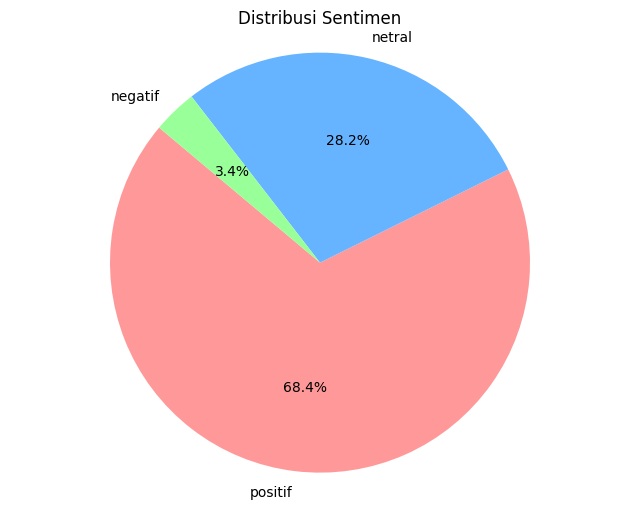

In [37]:
sentimen_counts = df_clean['sentimen'].value_counts()
labels = sentimen_counts.index
sizes = sentimen_counts.values
colors = ['#ff9999','#66b3ff','#99ff99']

plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Distribusi Sentimen')
plt.axis('equal')  
plt.show()

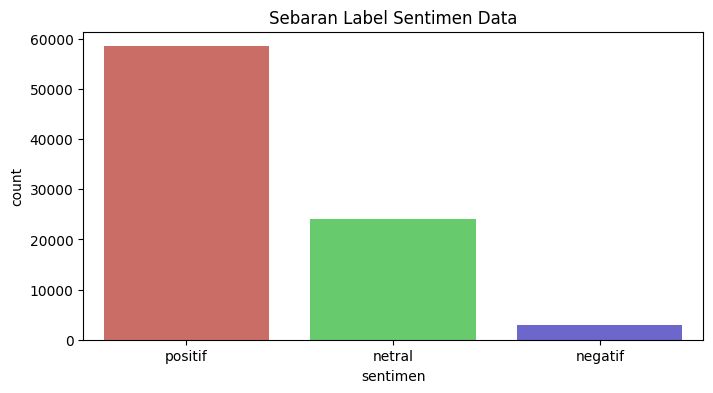

In [38]:
plt.figure(figsize=(8,4))
sns.countplot(x = 'sentimen', data = df_clean, hue = 'sentimen' ,palette='hls')
plt.title('Sebaran Label Sentimen Data')
plt.show()

In [39]:
def plot_wordcloud_and_frequency(df, text_column, label_column, stopwords, num_word = 10):
    labels = df[label_column].unique()
    num_cols = 2

    for label in labels:
        fig, axes = plt.subplots(1, num_cols, figsize=(12, 6))

        # Filter text by label
        text = " ".join(df[df[label_column] == label][text_column])

        # Generate wordcloud with a colormap
        wordcloud = WordCloud(width=400, height=400,
                              background_color='white',
                              stopwords=stopwords,
                              min_font_size=10,
                              colormap='viridis').generate(text)

        # Display wordcloud
        axes[0].imshow(wordcloud)
        axes[0].axis("off")
        axes[0].set_title(f'WordCloud - {label}')

        # Compute word frequency
        text_data = df[df[label_column] == label][text_column]
        word_frequency = text_data.str.split(expand=True).stack().value_counts()
        freq = word_frequency.head(num_word) # adjust numbers of word

        # Display word frequency bar plot with a color palette
        sns.barplot(x=freq.values, y=freq.index, ax=axes[1], hue = freq.values, palette="muted")
        axes[1].set_title(f'Word Frequency - {label}')
        axes[1].set_xlabel('Count')
        for p in axes[1].patches:
            axes[1].annotate("{:.0f}".format(p.get_width()), (p.get_x() + p.get_width(), p.get_y() + .5), ha='left', va='center')

        plt.tight_layout()
        plt.show()

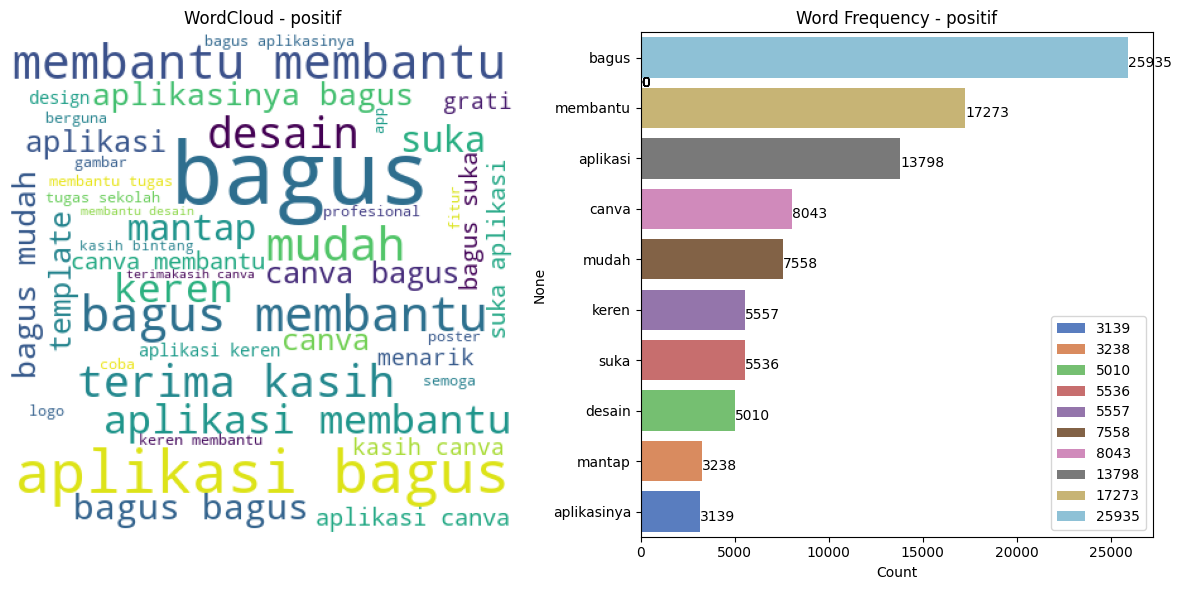

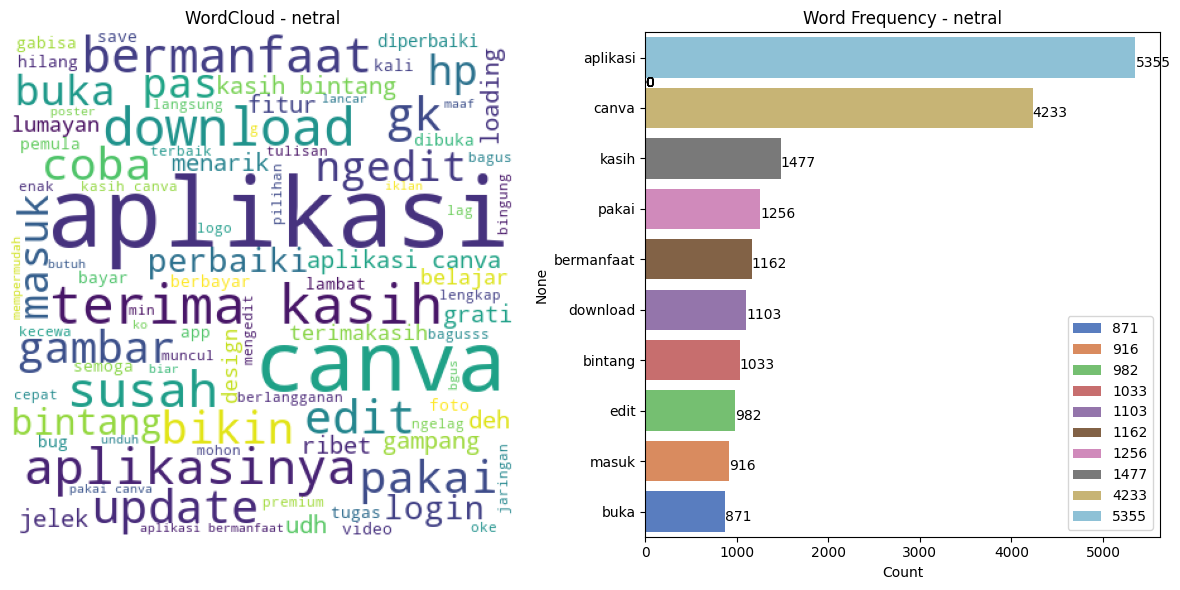

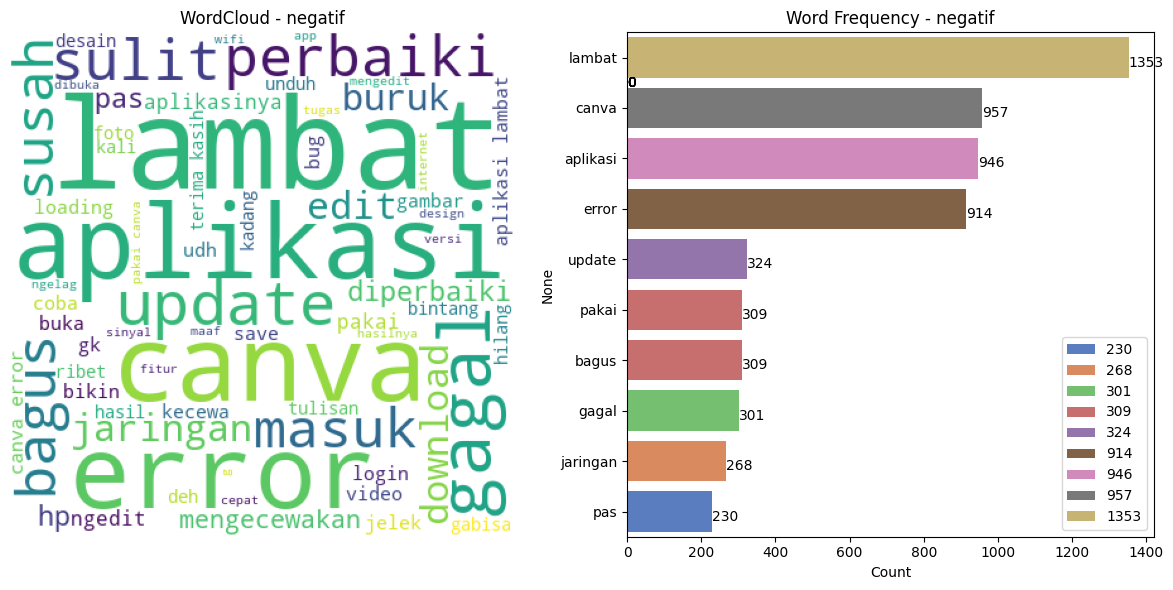

In [40]:
sw_id = set(stopwords.words('indonesian'))
plot_wordcloud_and_frequency(df_clean, 'text_result', 'sentimen', sw_id, 10)

## **Data Sampling**

Untuk menghemat sumber daya komputasi, data dikurangi 50%.

In [41]:
df_sampled = df_clean.sample(frac=0.5, random_state=42).reset_index(drop=True)
df_sampled.shape

(42750, 8)

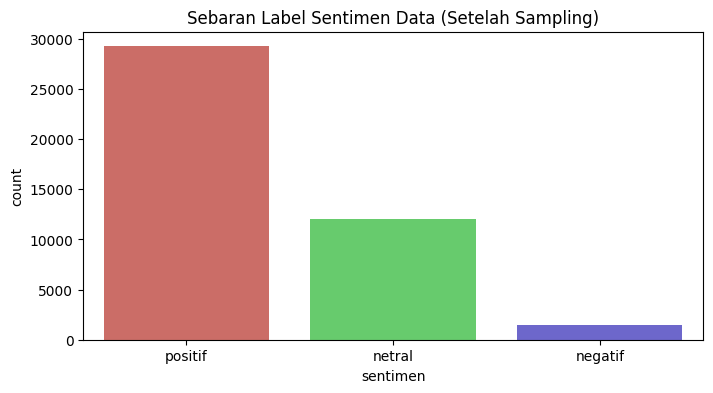

In [42]:
plt.figure(figsize=(8,4))
sns.countplot(x = 'sentimen', data = df_sampled, hue = 'sentimen' ,palette='hls')
plt.title('Sebaran Label Sentimen Data (Setelah Sampling)')
plt.show()

In [43]:
X = df_sampled['text_result']
y = df_sampled['sentimen']

In [44]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

## **Skema Pelatihan**

### **Skema 1**

**Ekstraksi Fitur** : TF-IDF

In [45]:
tfidf = TfidfVectorizer(max_features=300, min_df=20, max_df=0.8)
X_tfidf = tfidf.fit_transform(X)

In [46]:
df_features = pd.DataFrame(X_tfidf.toarray(), columns=tfidf.get_feature_names_out())
df_features

,akun,alhamdulillah,anak,android,aneh,apapun,apknya,apl,aplikasi,aplikasinya,...,upgrade,usaha,versi,video,vidio,wajib,warna,web,wifi,yah
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.449629,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42745,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.409005,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
42746,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.507226,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
42747,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.451777,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
42748,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Pembagian Data** : 80/20

In [47]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_tfidf, y, test_size=0.2, random_state=0)

**Pelatihan** : RNN

In [48]:
X_train_dense = X_train1.toarray()  
X_test_dense = X_test1.toarray()  

# Model RNN
model_rnn_tfidf = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_dense.shape[1],)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(len(label_encoder.classes_), activation='softmax') 
])

model_rnn_tfidf.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Latih model
history_rnn_tfidf = model_rnn_tfidf.fit(X_train_dense, y_train1, validation_data=(X_test_dense, y_test1), epochs=20, batch_size=32)

# Evaluasi model
loss_rnn_tfidf, accuracy_rnn_tfidf_test = model_rnn_tfidf.evaluate(X_test_dense, y_test1)
accuracy_rnn_tfidf_train = model_rnn_tfidf.evaluate(X_train_dense, y_train1)[1]

c:\Users\asus\AppData\Local\Programs\Python\Python311\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8073 - loss: 0.4513 - val_accuracy: 0.9835 - val_loss: 0.0619
Epoch 2/20
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9808 - loss: 0.0775 - val_accuracy: 0.9910 - val_loss: 0.0471
Epoch 3/20
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9870 - loss: 0.0566 - val_accuracy: 0.9918 - val_loss: 0.0441
Epoch 4/20
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9906 - loss: 0.0485 - val_accuracy: 0.9924 - val_loss: 0.0429
Epoch 5/20
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9907 - loss: 0.0465 - val_accuracy: 0.9930 - val_loss: 0.0405
Epoch 6/20
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9924 - loss: 0.0405 - val_accuracy: 0.9927 - val_loss: 0.0408
Epoch 7/20
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9928 - loss: 0.0387 - val_accuracy: 0.9936 - val_loss: 0.0403
Epoch 8/20
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9924 - loss: 0.0405 - 

In [49]:
print(f"Train Accuracy: {accuracy_rnn_tfidf_train:.4f}")
print(f"Test Accuracy: {accuracy_rnn_tfidf_test:.4f}")

Train Accuracy: 0.9964
Test Accuracy: 0.9923


### **Skema 2**

**Ekstraksi Fitur**: TF-IDF

In [50]:
tfidf = TfidfVectorizer(max_features=300, min_df=20, max_df=0.8)
X_tfidf = tfidf.fit_transform(X)

**Pembagian Data**: 70/30

In [51]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_tfidf, y, test_size=0.3, random_state=0)

**Pelatihan**: Random Forest

In [52]:
random_forest = RandomForestClassifier()
random_forest.fit(X_train2.toarray(), y_train2)

y_pred_train_rf = random_forest.predict(X_train2.toarray())
y_pred_test_rf = random_forest.predict(X_test2.toarray())

accuracy_train_rf = accuracy_score(y_train2, y_pred_train_rf)
accuracy_test_rf = accuracy_score(y_test2, y_pred_test_rf)

print('Train Accuracy:', accuracy_train_rf)
print('Test Accuracy:', accuracy_test_rf)

Train Accuracy: 0.9980952380952381
Test Accuracy: 0.9896296296296296


### **Skema 3**

**Ekstraksi Fitur**: Word2Vec

In [53]:
tokenized = df_sampled['tokenize_text']
model_w2v = Word2Vec(tokenized, vector_size=50, window=5, min_count=1, workers=4)

In [54]:
def avg_vector(sentence, model):
    word_vectors = [model.wv[word] for word in sentence if word in model.wv]
    if len(word_vectors) == 0:
        return np.zeros(model.vector_size)
    return np.mean(word_vectors, axis=0)

In [55]:
X_w2v = np.array([avg_vector(sentence, model_w2v) for sentence in tokenized])

**Pembagian Data**: 80/20

In [56]:
X_train3, X_test3, y_train3, y_test3 = train_test_split(X_w2v, y, test_size=0.2, random_state=42)

**Pelatihan**: CatBoost

In [57]:
catboost_model = CatBoostClassifier(verbose=0)
catboost_model.fit(X_train3, y_train3)

y_pred_test_catboost = catboost_model.predict(X_test3)
y_pred_train_catboost = catboost_model.predict(X_train3)

accuracy_train_catboost = accuracy_score(y_train3, y_pred_train_catboost)
accuracy_test_catboost = accuracy_score(y_test3, y_pred_test_catboost)

print("Train Accuracy:", accuracy_train_catboost)
print("Test Accuracy:", accuracy_test_catboost)

Train Accuracy: 0.9518421052631579
Test Accuracy: 0.8935672514619883


### **Skema 4**

**Ekstraksi Fitur** : Word2Vector

In [58]:
tokenized = df_sampled['tokenize_text']
model_w2v = Word2Vec(tokenized, vector_size=50, window=5, min_count=1, workers=4)

In [59]:
def avg_vector(sentence, model):
    word_vectors = [model.wv[word] for word in sentence if word in model.wv]
    if len(word_vectors) == 0:
        return np.zeros(model.vector_size)
    return np.mean(word_vectors, axis=0)

In [60]:
X_w2v = np.array([avg_vector(sentence, model_w2v) for sentence in tokenized])

**Pembagian Data** : 70/30

In [61]:
X_train4, X_test4, y_train4, y_test4 = train_test_split(X_w2v, y, test_size=0.3, random_state=42)

**Pelatihan** : RNN

In [62]:
X_train_dense = X_train4 
X_test_dense = X_test4  

# Model RNN
model_rnn_w2v = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_dense.shape[1],)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(len(label_encoder.classes_), activation='softmax') 
])

model_rnn_w2v.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Latih model
history_rnn_w2v = model_rnn_w2v.fit(X_train_dense, y_train4, validation_data=(X_test_dense, y_test4), epochs=20, batch_size=32)

# Evaluasi model
loss_rnn_w2v, accuracy_rnn_w2v_test = model_rnn_w2v.evaluate(X_test_dense, y_test4)
accuracy_rnn_w2v_train = model_rnn_w2v.evaluate(X_train_dense, y_train4)[1]

Epoch 1/20


c:\Users\asus\AppData\Local\Programs\Python\Python311\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


936/936 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.7509 - loss: 0.5914 - val_accuracy: 0.8499 - val_loss: 0.3702
Epoch 2/20
936/936 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8367 - loss: 0.4064 - val_accuracy: 0.8673 - val_loss: 0.3379
Epoch 3/20
936/936 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8504 - loss: 0.3744 - val_accuracy: 0.8732 - val_loss: 0.3194
Epoch 4/20
936/936 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8603 - loss: 0.3501 - val_accuracy: 0.8784 - val_loss: 0.3097
Epoch 5/20
936/936 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8626 - loss: 0.3415 - val_accuracy: 0.8809 - val_loss: 0.2945
Epoch 6/20
936/936 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8709 - loss: 0.3250 - val_accuracy: 0.8780 - val_loss: 0.2933
Epoch 7/20
936/936 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8684 - loss: 0.3272 - val_accuracy: 0.8892 - val_loss: 0.2822
Epoch 8/20
936/936 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8729 - loss: 0.3159 - val_accuracy: 0.8848 - val_

In [63]:
print(f"Train Accuracy: {accuracy_rnn_w2v_train:.4f}")
print(f"Test Accuracy: {accuracy_rnn_w2v_test:.4f}")

Train Accuracy: 0.9037
Test Accuracy: 0.8966


## **Evaluasi Hasil**

In [64]:
skema = ['RNN + TF-IDF (80/20)', 'Random Forest + TF-IDF (70/30)', 'CatBoost + Word2Vec (70/30)','RNN + Word2Vec (70/30)']
train_accuracy = [accuracy_rnn_tfidf_train, accuracy_train_rf, accuracy_train_catboost, accuracy_rnn_w2v_train]
test_accuracy = [accuracy_rnn_tfidf_test, accuracy_test_rf, accuracy_test_catboost, accuracy_rnn_w2v_test]

accuracy_df = pd.DataFrame({
    'Skema': skema,
    'Train Accuracy': train_accuracy,
    'Test Accuracy': test_accuracy
})

accuracy_df

,Skema,Train Accuracy,Test Accuracy
0,RNN + TF-IDF (80/20),0.996374,0.992281
1,Random Forest + TF-IDF (70/30),0.998095,0.989630
2,CatBoost + Word2Vec (70/30),0.951842,0.893567
3,RNN + Word2Vec (70/30),0.903693,0.896608


Seluruh skema menghasilkan training dan testing accuracy lebih dari 85%, dengan dua skema menghasilkan training dan testing accuracy lebih dari 92%.

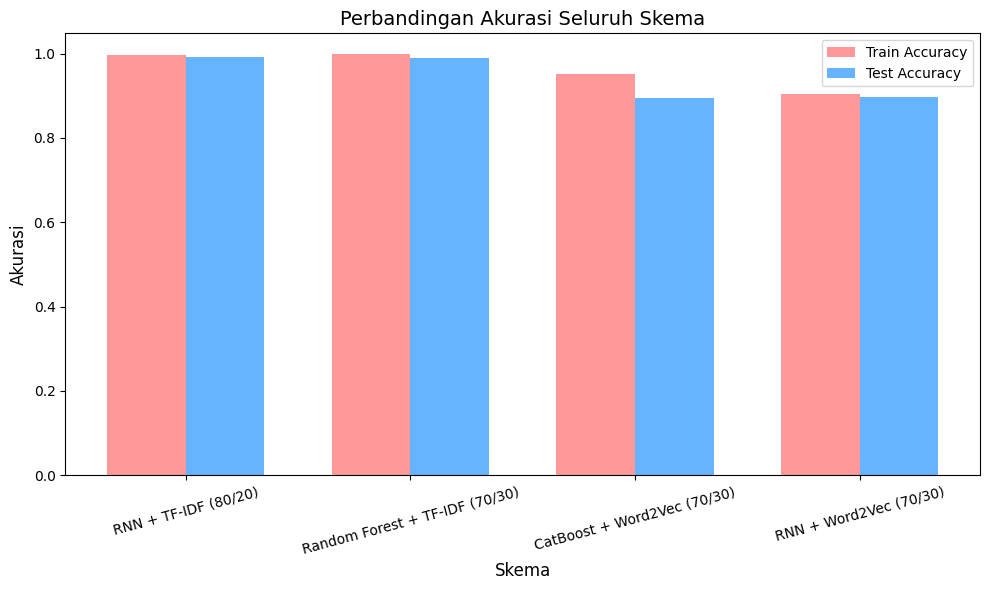

In [65]:
# Plot perbandingan akurasi
plt.figure(figsize=(10, 6))
bar_width = 0.35
index = np.arange(len(skema))

plt.bar(index, accuracy_df['Train Accuracy'], bar_width, label='Train Accuracy', color='#ff9999')
plt.bar(index + bar_width, accuracy_df['Test Accuracy'], bar_width, label='Test Accuracy', color='#66b3ff')

plt.xlabel('Skema', fontsize=12)
plt.ylabel('Akurasi', fontsize=12)
plt.title('Perbandingan Akurasi Seluruh Skema', fontsize=14)
plt.xticks(index + bar_width / 2, skema, rotation=15)
plt.legend()
plt.tight_layout()
plt.show()

## **Inference/Testing**

Algoritma RNN + TF-IDF mencapai akurasi tertinggi sebesar 99,23%. Oleh karena itu, algoritma ini dipilih sebagai model utama yang akan digunakan untuk memprediksi sentimen pada kalimat-kalimat baru.

In [66]:
# Input Kalimat
new_word = input("Masukkan kalimat baru: ")
print(f"Kalimat yang dimasukkan: {new_word}") 

# Preprocessing
new_word_cleaned = cleaning(new_word)
new_word_casefolded = casefolding(new_word_cleaned)
new_word_slangfixed = handle_slangwords(new_word_casefolded)
new_word_tokenized = tokenizing(new_word_slangfixed)
new_word_filtered = remove_stopwords(new_word_tokenized)
new_word_final = text_result(new_word_filtered)

# Ekstraksi Fitur
X_new = tfidf.transform([new_word_final])

# Prediksi Sentimen 
prediksi = model_rnn_tfidf.predict(X_new)

# Hasil prediksi
predicted_class = np.argmax(prediksi, axis=1)[0]  
if predicted_class == 2:  
    print("Sentimen kalimat POSITIF.")
elif predicted_class == 1: 
    print("Sentimen kalimat NETRAL.")
else: 
    print("Sentimen kalimat NEGATIF.")

Kalimat yang dimasukkan: memudahkan dalam membuat desain
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
Sentimen kalimat POSITIF.


In [67]:
# Input Kalimat
new_word = input("Masukkan kalimat baru: ")
print(f"Kalimat yang dimasukkan: {new_word}") 

# Preprocessing
new_word_cleaned = cleaning(new_word)
new_word_casefolded = casefolding(new_word_cleaned)
new_word_slangfixed = handle_slangwords(new_word_casefolded)
new_word_tokenized = tokenizing(new_word_slangfixed)
new_word_filtered = remove_stopwords(new_word_tokenized)
new_word_final = text_result(new_word_filtered)

# Ekstraksi Fitur
X_new = tfidf.transform([new_word_final])

# Prediksi Sentimen 
prediksi = model_rnn_tfidf.predict(X_new)

# Hasil prediksi
predicted_class = np.argmax(prediksi, axis=1)[0]  
if predicted_class == 2:  
    print("Sentimen kalimat POSITIF.")
elif predicted_class == 1: 
    print("Sentimen kalimat NETRAL.")
else: 
    print("Sentimen kalimat NEGATIF.")

Kalimat yang dimasukkan: mengecewakan fiturnya terbatas harus premium
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
Sentimen kalimat NEGATIF.
